In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
from matplotlib.pyplot import *
%matplotlib inline
import sys
sys.path.append('/Users/Poop/REU/')
sys.path.append('/Users/jeffrey/GoogleDrive/PulsarSignalSimulator/PulsarSimulator/')
import VersionZeroPointZero as PSS
import math
import numpy as np

In [3]:
rcParams['figure.figsize'] = (8.0,5.0)
rcParams.update({'font.size': 14})
from __future__ import division, print_function

In [4]:
def Disperse(self): # Broadens & delays pulse signal w transfer function defined in PSR Handbook, D. Lorimer and M. Kramer
    for x in range(4):
        global sig
        sig = self.signal[x] 
        DM = self.DM
        f0 = self.f0
        dt = self.TimeBinSize
        fourier = np.fft.rfft(sig)
        freqs = np.fft.rfftfreq(2*len(fourier)-1,d=dt/1e6)*1e3
        FinalFreqs = freqs-f0+1e-10 # Added the 1e-10 to avoid division by 0 errors in exponent
        H = np.exp(1j*2*np.pi*4.148808e9/((FinalFreqs+f0)*f0**2)*DM*FinalFreqs**2)
        product = fourier*H
        Dispersed = np.fft.irfft(product)
        global dispersed_sig
        dispersed_sig = np.asarray(Dispersed)

In [5]:
def plot_dispersed(pulsar_object, ism_object, signal_object): # Plots dispersed sig produced in ISM with Disperse()
    lim = pulsar_object.T/pulsar_object.Signal_in.TimeBinSize
    print(lim)
    if signal_object.SignalType == 'voltage':
        title('Voltage vs. Time')
        ylabel('Voltage')
        xlabel('Time (ms)')
        xlim(0,lim)
    elif signal_object.SignalType == 'intensity':
        title('Intensity vs. Time')
        ylabel('Intensity')
        xlabel('Time (ms)')
        xlim(0,lim)
    Disperse(ism_object)
    plot(sig+50)
    plot(dispersed_sig)
    show()

In [6]:
def FilterBank(array,step,sampling_freq):
    L = int(len(array)//step)
    print(L)
    PS = np.empty((step//2+1,L))
    for ii in range(L):
        start = ii*step
        stop = (ii+1)*step
        #PS[:,ii] = np.fft.rfft(x[start:stop])
        f, PS[:,ii] = sp.signal.periodogram(array[start:stop],sampling_freq)
    return PS

In [65]:
S1 = PSS.Signal(SignalType='voltage',Nt=10000)
P1 = PSS.Pulsar(S1,period=50)

In [66]:
P1.gauss_template(width=0.04)

In [67]:
P1.make_pulses()

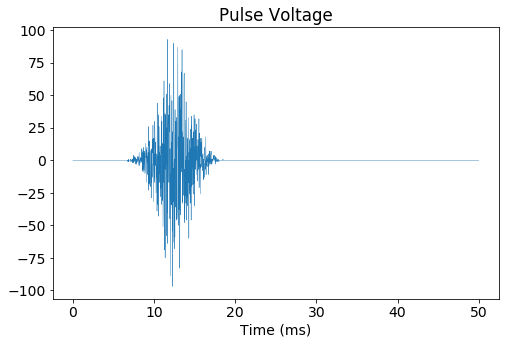

In [68]:
S1.pulse_plot()

In [69]:
F_pre =FilterBank(S1.signal[0,:],20,1)

500


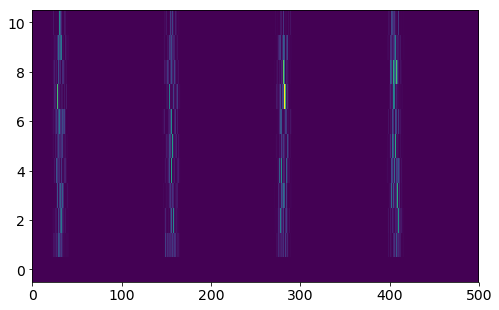

In [70]:
imshow(F_pre,aspect='auto',origin='left')

In [71]:
ISM1 = PSS.ISM(S1,DM=50)

In [72]:
Disperse(ISM1)

2500.0


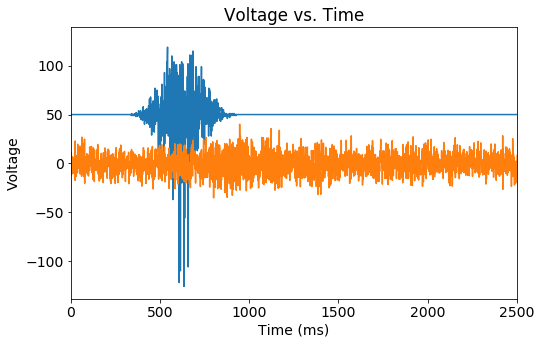

In [73]:
plot_dispersed(signal_object=S1,pulsar_object=P1,ism_object=ISM1)

In [74]:
#help(sp.signal.periodogram)

In [75]:
samp_freq = 1/(S1.TimeBinSize*1e-3)
print(samp_freq)
S1.Nt

50000.0


10000

In [76]:
FB1 = FilterBank(S1.signal[0,:],20,1)

500


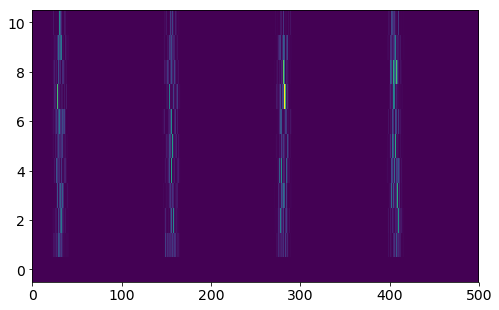

In [77]:
imshow(FB1,aspect='auto',origin='left')

In [78]:
FB2 = FilterBank(dispersed_sig,30,1)

333


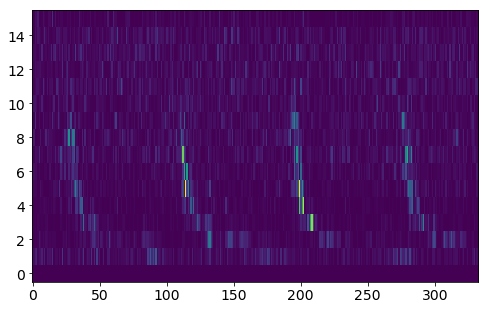

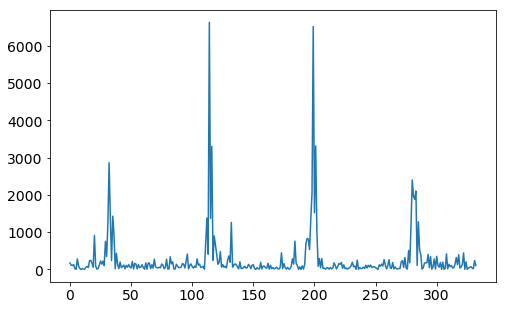

In [80]:
imshow(FB2,aspect='auto',origin='left')
show()
plot(FB2[5,:])
show()

__Amelia:__ This looks great!! You see that I've added a function I called FilterBank. What this is doing is taking the FFT of the voltage signal every `step`-number of time bins. It then separates the signal from that time slice into `step//2 + 1` frequency bins (basically the number of bins you'd get in an `numpy.fft.rfft()`. (That is the number of frequency bins in the `rfft` call). I'm using a special function from `scipy` called `scipy.periodogram()` which you can look up, if you want. It does some of the dirty work for us. Anyways, this FilterBank function does what the backend of a telescope would do to a real signal, like the voltage vs. time signal you are working on. It basically calculates the power in different frequencies at different times coming into the telescope. As you can see we're getting qualitatively getting the shape of a dispersed signal. So this means that even though the signal above has bled across the whole band, the FilterBank function still can distinguish the correct different frequencies at different times. 

The zero channel is the DC offset (i.e. the constant zeroth bin of the rfft). It's is empty because these signals are in fact average zero. 

We need to do some sort of test on this to see if we are dispersing by the correct amount. I have some ideas, but maybe we can talk about them on Monday. Also, as you can see we lose the signal at higher frequencies. That is because we aren't sampling at a high enough rate to seethose frequencies. We will need to incorporate some quick calculations to make sure we tell users whether their settings will be sufficient enough. 

The last thing, is that we need to decide how we want to add this signal to the simulator. In general the simulator doesn't really use `global` parameters. It's a nice use here, but we'll want to define something in the simulator that hold the signal for this instance. One could easily imagine a time when someone wants to compare 2 signals, and your function, as it stands, will just write over the `dispersed_sig` array with which ever is calculated last. Normally I actually change the `signal_object.signal` array, but we should decide if that is the best thing to do. 

Again, this is really fanatastic. 

__Amelia:__ One last thing. I've added a call to `__future__` at the beginning of the notebook. The simulator is written in `Python 3`, and we want to continue doing that. By importing those functions we can use `Python 3` syntax (print has parenthesis, definition of division `//` vs `/`, and so on).